<a href="https://colab.research.google.com/github/sophia-moore/232-Final-Project/blob/main/Lapeig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy.sparse import csgraph
from scipy.spatial.distance import cdist


# Load CSV
data = pd.read_csv("/content/drive/MyDrive/AMTH 232 Final project/BoW, GloVe Matrices/TRAIN TEST/glove_train_tfidf.csv")
data = data.head(10000)

# Dimension reduce using PCA (10 components)
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(data)

# define X_train
X_train = reduced_data

# defining some sigma
sigma = sigma = 3 * np.median(cdist(X_train, X_train, metric="euclidean")) # Median distance (do we need to change this)

# adjacency
W = rbf_kernel(X_train, gamma=1.0 / (2 * sigma**2))

# Building degree matrix and normalised lap
D = np.diag(W.sum(axis=1))
L = csgraph.laplacian(W, normed=True)  # symmetric normalized Laplacian


# extracting eigenvalues and eigenvectors
from scipy.sparse.linalg import eigsh

k = 2  # number of dimensions for embedding
eigvals, eigvecs = eigsh(L, k=k+1, which='SM')  # skip the trivial zero eigenvalue
eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]  # remove first eigenvector (constant)

print(eigvals)
print(eigvecs)

# Nystrom extension

from scipy.spatial.distance import cdist

def nystrom_extension(X_test, X_train, Z_train, lambda_vals, sigma):
    """
    Apply Nyström extension to embed test points into Laplacian Eigenmap space.

    Parameters:
        X_test:       (n_test, d)    PCA-reduced test data
        X_train:      (n_train, d)   PCA-reduced training data
        Z_train:      (n_train, k)   eigenvectors from Laplacian (Z_train)
        lambda_vals:  (k,)           eigenvalues (lambda_1 to lambda_k)
        sigma:        float          bandwidth used in the RBF kernel

    Returns:
        Z_test:       (n_test, k)    estimated embeddings for X_test
    """
    # Step 1: compute pairwise squared distances
    dists = cdist(X_test, X_train, metric="sqeuclidean")  # shape: (n_test, n_train)

    # Step 2: kernel weights to training points
    W_test = np.exp(-dists / (2 * sigma**2))  # shape: (n_test, n_train)

    # Step 3: compute degrees
    d_test = W_test.sum(axis=1, keepdims=True)           # (n_test, 1)
    d_train = np.sum(W_test, axis=0, keepdims=True)      # (1, n_train)

    # Step 4: normalize weights
    W_tilde = W_test / np.sqrt(d_test @ d_train)         # shape: (n_test, n_train)

    # Step 5: compute Z_test via Nyström extension
    Z_test = (W_tilde @ Z_train) / lambda_vals           # (n_test, k) / (k,) — broadcasts

    return Z_test

# testing data
# Load CSV
data_test = pd.read_csv("/content/drive/MyDrive/AMTH 232 Final project/BoW, GloVe Matrices/TRAIN TEST/glove_test_tfidf.csv")
data_test = data_test.head(10000)

# Dimension reduce using PCA (10 components)
pca_test = PCA(n_components=10)
reduced_data_test = pca.fit_transform(data)

# define X_test
X_test = reduced_data_test

Z_train = eigvecs

Z_test = nystrom_extension(X_test, X_train, eigvecs, eigvals, sigma)

#np.save("Z_train_lap_glove_tfidf.npy", Z_train)
#np.save("Z_test_lap_glove_tfidf.npy", Z_test)



[0.96676344 0.97807905]
[[ 0.00283757 -0.00057084]
 [ 0.00363675 -0.00018588]
 [ 0.00177231 -0.00577313]
 ...
 [ 0.00177474 -0.00407145]
 [ 0.00073973 -0.00789744]
 [ 0.00251423  0.0038257 ]]


In [ ]:
print(Z_train.shape)
print(Z_test.shape)

(10000, 2)
(10000, 2)


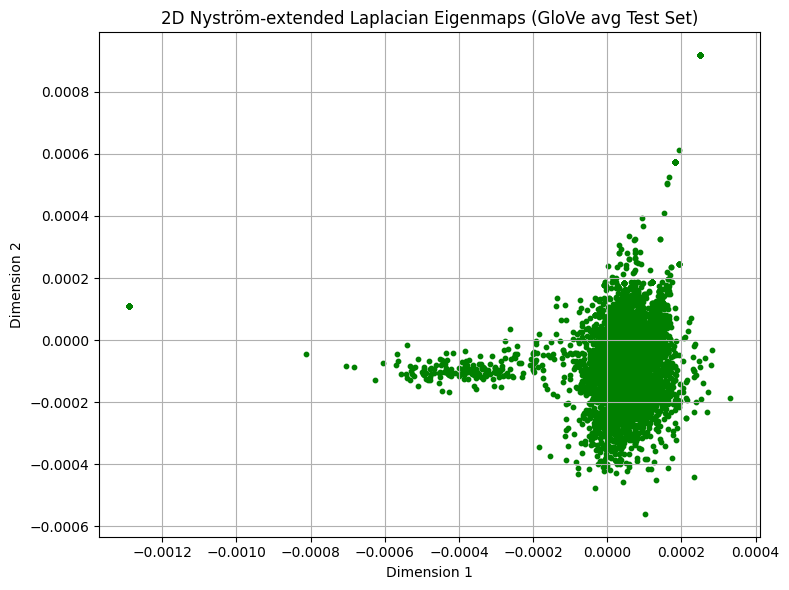

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(Z_test[:, 0], Z_test[:, 1], s=10, c='green')
plt.title("2D Nyström-extended Laplacian Eigenmaps (GloVe avg Test Set)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("laplacian_embedding_test.png")
plt.show()



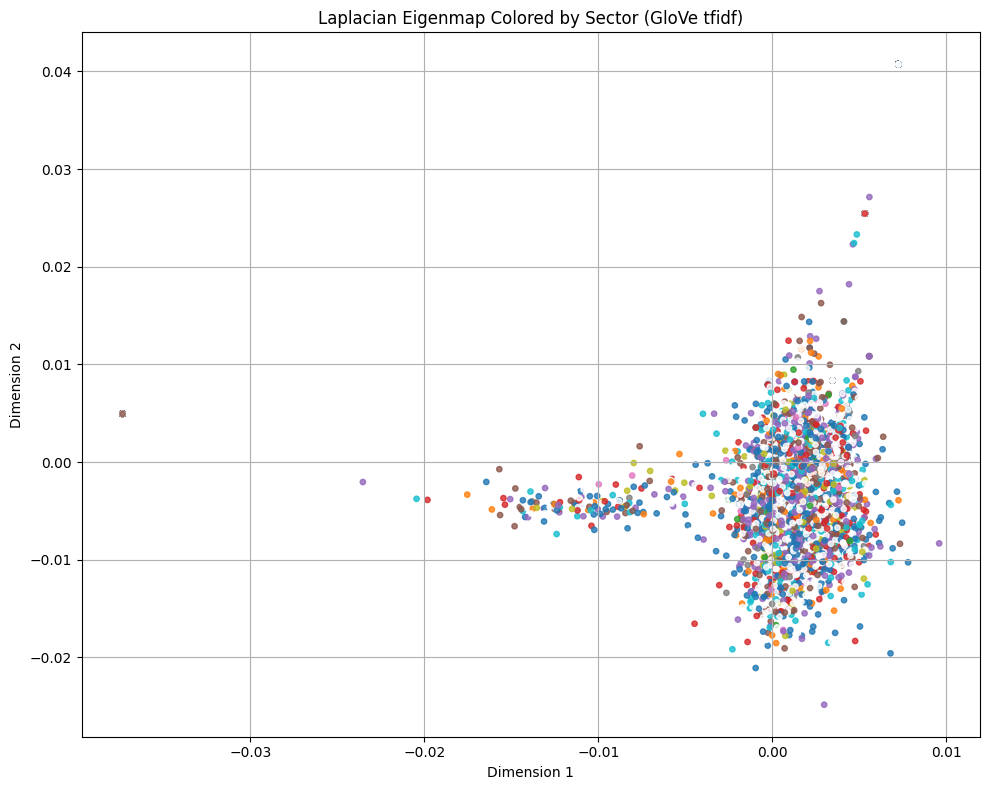

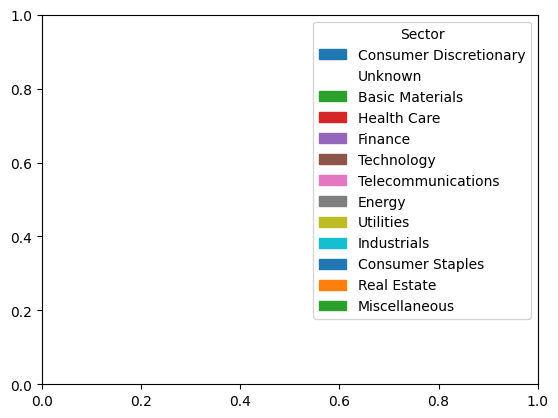

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

meta_df = pd.read_csv("/content/drive/MyDrive/AMTH 232 Final project/BoW, GloVe Matrices/OG_data_with_sector_without_NA")
meta_df = meta_df.head(10000)

# Make sure 'Sector' is a string and fill NaNs with 'Unknown'
meta_df["Sector"] = meta_df["Sector"].fillna("Unknown").astype(str)

# Define a color palette (e.g., 10–15 distinct colors + gray for unknowns)
unique_sectors = meta_df["Sector"].unique()
palette = sns.color_palette("tab10", len(unique_sectors))  # you can use 'Set2' or others
sector_color_map = dict(zip(unique_sectors, palette))
sector_color_map["Unknown"] = "white"  # override if needed

# Map sectors to colors
sector_colors = meta_df["Sector"].map(sector_color_map)

plt.figure(figsize=(10, 8))
plt.scatter(Z_train[:, 0], Z_train[:, 1], c=sector_colors, s=15, alpha=0.8)
plt.title("Laplacian Eigenmap Colored by Sector (GloVe tfidf)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

legend_handles = [
    mpatches.Patch(color=sector_color_map[sector], label=sector)
    for sector in unique_sectors
]
plt.legend(handles=legend_handles, title="Sector", loc='best')  # ← Changed this line
plt.show()



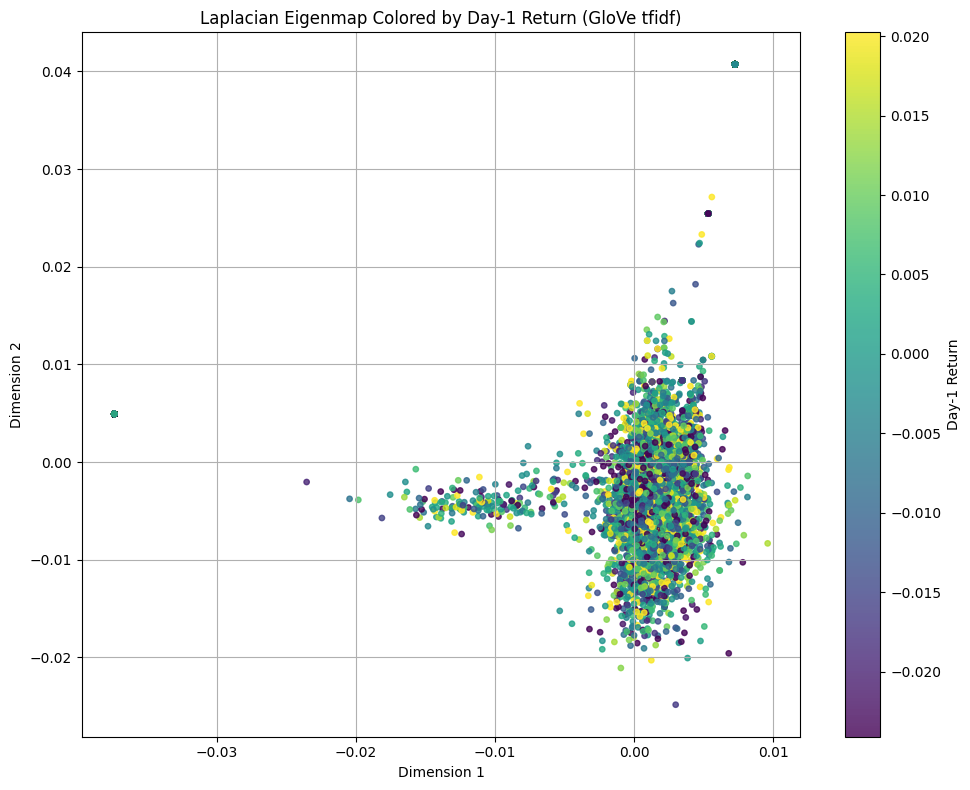

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Get the Day1_Return values
returns = meta_df["Day1_Return"].values

vmin = np.percentile(returns, 10)   # 5th percentile
vmax = np.percentile(returns, 90)  # 95th percentile

# Create the scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(Z_train[:, 0], Z_train[:, 1],
                 c=returns, cmap='viridis', s=15, alpha=0.8,
                 vmin=vmin, vmax=vmax)


plt.title("Laplacian Eigenmap Colored by Day-1 Return (GloVe tfidf)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.colorbar(sc, label="Day-1 Return")  # Adds a color scale legend
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy.sparse import csgraph
from scipy.spatial.distance import cdist


# Load CSV
data = pd.read_csv("glove_train_tfidf.csv")
data = data.head(10000)

# Dimension reduce using PCA (10 components)
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(data)

# define X_train
X_train = reduced_data

# defining some sigma
sigma = sigma = 3 * np.median(cdist(X_train, X_train, metric="euclidean")) # Median distance (do we need to change this)

# adjacency
W = rbf_kernel(X_train, gamma=1.0 / (2 * sigma**2))


# Building degree matrix and normalised lap
D = np.diag(W.sum(axis=1))
L = csgraph.laplacian(W, normed=True)  # symmetric normalized Laplacian


# extracting eigenvalues and eigenvectors
from scipy.sparse.linalg import eigsh

k = 2  # number of dimensions for embedding
eigvals, eigvecs = eigsh(L, k=k+1, which='SM')  # skip the trivial zero eigenvalue
eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]  # remove first eigenvector (constant)

print(eigvals)
print(eigvecs)

# Nystrom extension

from scipy.spatial.distance import cdist

def nystrom_extension(X_test, X_train, Z_train, lambda_vals, sigma):
    """
    Apply Nyström extension to embed test points into Laplacian Eigenmap space.

    Parameters:
        X_test:       (n_test, d)    PCA-reduced test data
        X_train:      (n_train, d)   PCA-reduced training data
        Z_train:      (n_train, k)   eigenvectors from Laplacian (Z_train)
        lambda_vals:  (k,)           eigenvalues (lambda_1 to lambda_k)
        sigma:        float          bandwidth used in the RBF kernel

    Returns:
        Z_test:       (n_test, k)    estimated embeddings for X_test
    """
    # Step 1: compute pairwise squared distances
    dists = cdist(X_test, X_train, metric="sqeuclidean")  # shape: (n_test, n_train)

    # Step 2: kernel weights to training points
    W_test = np.exp(-dists / (2 * sigma**2))  # shape: (n_test, n_train)

    # Step 3: compute degrees
    d_test = W_test.sum(axis=1, keepdims=True)           # (n_test, 1)
    d_train = np.sum(W_test, axis=0, keepdims=True)      # (1, n_train)

    # Step 4: normalize weights
    W_tilde = W_test / np.sqrt(d_test @ d_train)         # shape: (n_test, n_train)

    # Step 5: compute Z_test via Nyström extension
    Z_test = (W_tilde @ Z_train) / lambda_vals           # (n_test, k) / (k,) — broadcasts

    return Z_test

# testing data
# Load CSV
data_test = pd.read_csv("glove_test_tfidf.csv")
data_test = data_test.head(10000)

# Dimension reduce using PCA (10 components)
pca_test = PCA(n_components=10)
reduced_data_test = pca.fit_transform(data)
print("test PCA complete")

# define X_test
X_test = reduced_data_test


Z_test = nystrom_extension(X_test, X_train, eigvecs, eigvals, sigma)



In [ ]:
import pickle


with open('/content/DJN_2017-01 (1).pkl', 'rb') as f:
    full_data = pickle.load(f)


<ipython-input-18-0ec4c17b2b2d>:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  full_data = pickle.load(f)


In [ ]:
print(full_data.head(20))

print(full_data.shape)

        Date     Company                                              Title  \
0   20170101    [ATC.AE]  [press, release, murphy, owner, kxly, abc, cha...   
1   20170101      [ARKR]  [ark, restaurant, apos, ceo, weinstein, result...   
2   20170101         [F]  [like, futurist, be, prepare, totally, unexpec...   
3   20170101      [NCOM]  [press, release, national, commerce, corporati...   
4   20170101       [EDE]  [press, release, district, electric, company, ...   
5   20170101      [SCOR]  [press, release, comscore, report, north, movi...   
6   20170102     [UKDAY]  [morning, brief, manufacturing, pmis, top, age...   
7   20170102  [WRT1V.HE]  [wartsila, wärtsilä, increase, safety, predict...   
8   20170102  [WRT1V.HE]  [press, release, wartsila, wärtsilä, increase,...   
9   20170102      [TWTR]  [late, twitter, exec, depart, great, china, he...   
10  20170102      [CEFC]  [commercial, national, financial, corporation,...   
11  20170102       [ODP]  [press, release, office, d